In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *


import keras_tuner as kt
from GraphTransformerPrerocess import graph_water_transformer_cov_process
from graph import graph_topology_5
from models.graph_water_transformer_cov import graph_water_transformer_cov

2023-07-22 01:13:29.820386: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-22 01:13:31.491501: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

### Parameters

In [3]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5


# ===== model parameters ======
head_size = 96*2
num_heads = 3
ff_dim = 96
num_transformer_blocks = 1
dropout = 0.5
atte_reg = 1e-2
l1_reg = 1e-5
l2_reg = 1e-5
gcn_unit1 = 32
gcn_unit2 = 16
lstm_units = 32
learning_rate = 5e-4
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 500
EPOCHS = 3000
BATCH = 512

### Preprocess

In [4]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = graph_water_transformer_cov_process(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [5]:
print(train_cov.shape, val_cov.shape, test_cov.shape, 
train_tws_reshape.shape, val_tws_reshape.shape, test_tws_reshape.shape, \
train_ws_y.shape, val_ws_y.shape, test_ws_y.shape)

(77069, 96, 12) (9634, 96, 12) (19268, 96, 12) (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) (77069, 96) (9634, 96) (19268, 96)


In [6]:
train_cov = train_cov[:, :n_hours, :]
val_cov = val_cov[:, :n_hours, :]
test_cov = test_cov[:, :n_hours, :]

In [7]:
print(train_cov.shape, val_cov.shape, test_cov.shape, 
train_tws_reshape.shape, val_tws_reshape.shape, test_tws_reshape.shape, \
train_ws_y.shape, val_ws_y.shape, test_ws_y.shape)

(77069, 72, 12) (9634, 72, 12) (19268, 72, 12) (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) (77069, 96) (9634, 96) (19268, 96)


### Graph topology

In [8]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


### Model

In [9]:
input_shape = train_cov.shape[1:]

In [10]:
model, GCNConv = graph_water_transformer_cov(input_shape=input_shape,
                                             gcn1=gcn_unit1,
                                             gcn2=gcn_unit2,
                                             lstm_unit=lstm_units, 
                                             num_transformer_blocks=num_transformer_blocks,
                                             head_size=head_size,
                                             num_heads=num_heads,
                                             ff_dim=ff_dim, 
                                             atte_reg=atte_reg, 
                                             l1_reg=l1_reg, 
                                             l2_reg=l2_reg, 
                                             dropout=dropout,
                                             masked_value=masked_value
                                            )
model.summary()

2023-07-22 01:13:40.690294: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 cov_inputs (InputLayer)     [(None, 72, 12)]             0         []                            
                                                                                                  
 masking (Masking)           (None, 72, 12)               0         ['cov_inputs[0][0]']          
                                                                                                  
 multi_head_attention (Mult  (None, 72, 12)               29388     ['masking[0][0]',             
 iHeadAttention)                                                     'masking[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 72, 12)               0         ['multi_head_attention[0][

In [11]:
print(train_cov.shape, train_tws_reshape.shape, train_adj_mat.shape)
print(val_cov.shape, val_tws_reshape.shape, val_adj_mat.shape)
print(test_cov.shape, test_tws_reshape.shape, test_adj_mat.shape)

(77069, 72, 12) (77069, 5, 72) (77069, 5, 5)
(9634, 72, 12) (9634, 5, 72) (9634, 5, 5)
(19268, 72, 12) (19268, 5, 72) (19268, 5, 5)


In [12]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate, 
                                                          decay_steps=decay_steps,
                                                          decay_rate=decay_rate)

model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='mse',
              metrics=['mae']
             )


es = EarlyStopping(monitor='val_mae', mode='min', verbose=2, patience=PATIENCE)
mc = ModelCheckpoint('saved_models/graph_water_transformer_cov_gate_pump_nofuture.h5', 
                     monitor='val_mae', 
                     mode='min', 
                     verbose=2, 
                     custom_objects={'GCNConv': GCNConv},
                     save_best_only=True
                    )


model.fit([train_cov, train_tws_reshape, train_adj_mat], train_ws_y,
          validation_data=([test_cov, test_tws_reshape, test_adj_mat], test_ws_y),
          epochs=EPOCHS,
          batch_size=BATCH,
          verbose=2,
          shuffle=True,
          callbacks=[es, mc]
         )

Epoch 1/3000


2023-07-22 01:14:04.988801: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-07-22 01:14:06.128908: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f2bb400c390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-22 01:14:06.128968: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-07-22 01:14:06.139586: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-22 01:14:06.511412: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_mae improved from inf to 0.09312, saving model to saved_models/graph_water_transformer_cov_gate_pump_nofuture.h5
151/151 - 20s - loss: 0.3111 - mae: 0.2565 - val_loss: 0.0542 - val_mae: 0.0931 - 20s/epoch - 132ms/step
Epoch 2/3000


/aul/homes/jshi008/miniconda3/envs/tf213/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_mae improved from 0.09312 to 0.07000, saving model to saved_models/graph_water_transformer_cov_gate_pump_nofuture.h5
151/151 - 6s - loss: 0.0324 - mae: 0.0944 - val_loss: 0.0150 - val_mae: 0.0700 - 6s/epoch - 41ms/step
Epoch 3/3000

Epoch 3: val_mae improved from 0.07000 to 0.06203, saving model to saved_models/graph_water_transformer_cov_gate_pump_nofuture.h5
151/151 - 6s - loss: 0.0130 - mae: 0.0681 - val_loss: 0.0106 - val_mae: 0.0620 - 6s/epoch - 40ms/step
Epoch 4/3000

Epoch 4: val_mae improved from 0.06203 to 0.05693, saving model to saved_models/graph_water_transformer_cov_gate_pump_nofuture.h5
151/151 - 6s - loss: 0.0096 - mae: 0.0564 - val_loss: 0.0094 - val_mae: 0.0569 - 6s/epoch - 40ms/step
Epoch 5/3000

Epoch 5: val_mae improved from 0.05693 to 0.05382, saving model to saved_models/graph_water_transformer_cov_gate_pump_nofuture.h5
151/151 - 6s - loss: 0.0082 - mae: 0.0493 - val_loss: 0.0087 - val_mae: 0.0538 - 6s/epoch - 40ms/step
Epoch 6/3000

Epoch 6: val_ma

Epoch 39/3000

Epoch 39: val_mae improved from 0.03237 to 0.03210, saving model to saved_models/graph_water_transformer_cov_gate_pump_nofuture.h5
151/151 - 6s - loss: 0.0016 - mae: 0.0199 - val_loss: 0.0025 - val_mae: 0.0321 - 6s/epoch - 40ms/step
Epoch 40/3000

Epoch 40: val_mae improved from 0.03210 to 0.03161, saving model to saved_models/graph_water_transformer_cov_gate_pump_nofuture.h5
151/151 - 6s - loss: 0.0016 - mae: 0.0198 - val_loss: 0.0024 - val_mae: 0.0316 - 6s/epoch - 40ms/step
Epoch 41/3000

Epoch 41: val_mae did not improve from 0.03161
151/151 - 6s - loss: 0.0015 - mae: 0.0196 - val_loss: 0.0024 - val_mae: 0.0320 - 6s/epoch - 40ms/step
Epoch 42/3000

Epoch 42: val_mae did not improve from 0.03161
151/151 - 6s - loss: 0.0014 - mae: 0.0194 - val_loss: 0.0023 - val_mae: 0.0317 - 6s/epoch - 40ms/step
Epoch 43/3000

Epoch 43: val_mae did not improve from 0.03161
151/151 - 6s - loss: 0.0013 - mae: 0.0194 - val_loss: 0.0023 - val_mae: 0.0324 - 6s/epoch - 40ms/step
Epoch 44/300

Epoch 83/3000

Epoch 83: val_mae did not improve from 0.02830
151/151 - 6s - loss: 5.8997e-04 - mae: 0.0173 - val_loss: 0.0014 - val_mae: 0.0283 - 6s/epoch - 40ms/step
Epoch 84/3000

Epoch 84: val_mae did not improve from 0.02830
151/151 - 6s - loss: 5.8462e-04 - mae: 0.0172 - val_loss: 0.0014 - val_mae: 0.0285 - 6s/epoch - 40ms/step
Epoch 85/3000

Epoch 85: val_mae improved from 0.02830 to 0.02822, saving model to saved_models/graph_water_transformer_cov_gate_pump_nofuture.h5
151/151 - 6s - loss: 5.8735e-04 - mae: 0.0173 - val_loss: 0.0014 - val_mae: 0.0282 - 6s/epoch - 40ms/step
Epoch 86/3000

Epoch 86: val_mae improved from 0.02822 to 0.02806, saving model to saved_models/graph_water_transformer_cov_gate_pump_nofuture.h5
151/151 - 6s - loss: 5.8718e-04 - mae: 0.0173 - val_loss: 0.0013 - val_mae: 0.0281 - 6s/epoch - 40ms/step
Epoch 87/3000

Epoch 87: val_mae did not improve from 0.02806
151/151 - 6s - loss: 5.8261e-04 - mae: 0.0172 - val_loss: 0.0013 - val_mae: 0.0281 - 6s/epoch - 39

Epoch 127/3000

Epoch 127: val_mae did not improve from 0.02634
151/151 - 6s - loss: 5.5235e-04 - mae: 0.0167 - val_loss: 0.0012 - val_mae: 0.0266 - 6s/epoch - 39ms/step
Epoch 128/3000

Epoch 128: val_mae did not improve from 0.02634
151/151 - 6s - loss: 5.4852e-04 - mae: 0.0166 - val_loss: 0.0012 - val_mae: 0.0266 - 6s/epoch - 39ms/step
Epoch 129/3000

Epoch 129: val_mae improved from 0.02634 to 0.02587, saving model to saved_models/graph_water_transformer_cov_gate_pump_nofuture.h5
151/151 - 6s - loss: 5.4947e-04 - mae: 0.0166 - val_loss: 0.0012 - val_mae: 0.0259 - 6s/epoch - 40ms/step
Epoch 130/3000

Epoch 130: val_mae did not improve from 0.02587
151/151 - 6s - loss: 5.4921e-04 - mae: 0.0166 - val_loss: 0.0012 - val_mae: 0.0264 - 6s/epoch - 39ms/step
Epoch 131/3000

Epoch 131: val_mae did not improve from 0.02587
151/151 - 6s - loss: 5.4826e-04 - mae: 0.0166 - val_loss: 0.0013 - val_mae: 0.0272 - 6s/epoch - 39ms/step
Epoch 132/3000

Epoch 132: val_mae did not improve from 0.02587
15

Epoch 174/3000

Epoch 174: val_mae did not improve from 0.02529
151/151 - 6s - loss: 5.3496e-04 - mae: 0.0164 - val_loss: 0.0012 - val_mae: 0.0264 - 6s/epoch - 39ms/step
Epoch 175/3000

Epoch 175: val_mae did not improve from 0.02529
151/151 - 6s - loss: 5.3269e-04 - mae: 0.0163 - val_loss: 0.0013 - val_mae: 0.0275 - 6s/epoch - 39ms/step
Epoch 176/3000

Epoch 176: val_mae did not improve from 0.02529
151/151 - 6s - loss: 5.3401e-04 - mae: 0.0164 - val_loss: 0.0012 - val_mae: 0.0266 - 6s/epoch - 39ms/step
Epoch 177/3000

Epoch 177: val_mae did not improve from 0.02529
151/151 - 6s - loss: 5.3407e-04 - mae: 0.0164 - val_loss: 0.0012 - val_mae: 0.0261 - 6s/epoch - 39ms/step
Epoch 178/3000

Epoch 178: val_mae did not improve from 0.02529
151/151 - 6s - loss: 5.3380e-04 - mae: 0.0164 - val_loss: 0.0012 - val_mae: 0.0260 - 6s/epoch - 40ms/step
Epoch 179/3000

Epoch 179: val_mae did not improve from 0.02529
151/151 - 6s - loss: 5.3416e-04 - mae: 0.0164 - val_loss: 0.0012 - val_mae: 0.0267 - 6

151/151 - 6s - loss: 5.2175e-04 - mae: 0.0162 - val_loss: 0.0011 - val_mae: 0.0256 - 6s/epoch - 39ms/step
Epoch 223/3000

Epoch 223: val_mae did not improve from 0.02529
151/151 - 6s - loss: 5.2370e-04 - mae: 0.0162 - val_loss: 0.0011 - val_mae: 0.0254 - 6s/epoch - 39ms/step
Epoch 224/3000

Epoch 224: val_mae did not improve from 0.02529
151/151 - 6s - loss: 5.2253e-04 - mae: 0.0162 - val_loss: 0.0012 - val_mae: 0.0269 - 6s/epoch - 39ms/step
Epoch 225/3000

Epoch 225: val_mae did not improve from 0.02529
151/151 - 6s - loss: 5.2271e-04 - mae: 0.0162 - val_loss: 0.0012 - val_mae: 0.0258 - 6s/epoch - 40ms/step
Epoch 226/3000

Epoch 226: val_mae did not improve from 0.02529
151/151 - 6s - loss: 5.2418e-04 - mae: 0.0162 - val_loss: 0.0012 - val_mae: 0.0264 - 6s/epoch - 39ms/step
Epoch 227/3000

Epoch 227: val_mae did not improve from 0.02529
151/151 - 6s - loss: 5.2607e-04 - mae: 0.0163 - val_loss: 0.0011 - val_mae: 0.0256 - 6s/epoch - 39ms/step
Epoch 228/3000

Epoch 228: val_mae did not i

Epoch 270/3000

Epoch 270: val_mae did not improve from 0.02488
151/151 - 6s - loss: 5.1897e-04 - mae: 0.0162 - val_loss: 0.0011 - val_mae: 0.0254 - 6s/epoch - 40ms/step
Epoch 271/3000

Epoch 271: val_mae did not improve from 0.02488
151/151 - 6s - loss: 5.1733e-04 - mae: 0.0161 - val_loss: 0.0012 - val_mae: 0.0260 - 6s/epoch - 40ms/step
Epoch 272/3000

Epoch 272: val_mae did not improve from 0.02488
151/151 - 6s - loss: 5.1968e-04 - mae: 0.0162 - val_loss: 0.0011 - val_mae: 0.0254 - 6s/epoch - 39ms/step
Epoch 273/3000

Epoch 273: val_mae did not improve from 0.02488
151/151 - 6s - loss: 5.2000e-04 - mae: 0.0162 - val_loss: 0.0011 - val_mae: 0.0255 - 6s/epoch - 39ms/step
Epoch 274/3000

Epoch 274: val_mae did not improve from 0.02488
151/151 - 6s - loss: 5.1638e-04 - mae: 0.0161 - val_loss: 0.0012 - val_mae: 0.0258 - 6s/epoch - 39ms/step
Epoch 275/3000

Epoch 275: val_mae did not improve from 0.02488
151/151 - 6s - loss: 5.1909e-04 - mae: 0.0161 - val_loss: 0.0011 - val_mae: 0.0255 - 6

Epoch 318/3000

Epoch 318: val_mae did not improve from 0.02484
151/151 - 6s - loss: 5.1290e-04 - mae: 0.0160 - val_loss: 0.0011 - val_mae: 0.0255 - 6s/epoch - 39ms/step
Epoch 319/3000

Epoch 319: val_mae did not improve from 0.02484
151/151 - 6s - loss: 5.1446e-04 - mae: 0.0161 - val_loss: 0.0011 - val_mae: 0.0258 - 6s/epoch - 39ms/step
Epoch 320/3000

Epoch 320: val_mae did not improve from 0.02484
151/151 - 6s - loss: 5.1089e-04 - mae: 0.0160 - val_loss: 0.0011 - val_mae: 0.0255 - 6s/epoch - 39ms/step
Epoch 321/3000

Epoch 321: val_mae did not improve from 0.02484
151/151 - 6s - loss: 5.1475e-04 - mae: 0.0161 - val_loss: 0.0011 - val_mae: 0.0254 - 6s/epoch - 39ms/step
Epoch 322/3000

Epoch 322: val_mae did not improve from 0.02484
151/151 - 6s - loss: 5.1096e-04 - mae: 0.0160 - val_loss: 0.0011 - val_mae: 0.0253 - 6s/epoch - 39ms/step
Epoch 323/3000

Epoch 323: val_mae did not improve from 0.02484
151/151 - 6s - loss: 5.1318e-04 - mae: 0.0160 - val_loss: 0.0011 - val_mae: 0.0254 - 6

Epoch 366/3000

Epoch 366: val_mae did not improve from 0.02462
151/151 - 6s - loss: 5.1038e-04 - mae: 0.0160 - val_loss: 0.0011 - val_mae: 0.0256 - 6s/epoch - 39ms/step
Epoch 367/3000

Epoch 367: val_mae did not improve from 0.02462
151/151 - 6s - loss: 5.1232e-04 - mae: 0.0161 - val_loss: 0.0011 - val_mae: 0.0257 - 6s/epoch - 39ms/step
Epoch 368/3000

Epoch 368: val_mae did not improve from 0.02462
151/151 - 6s - loss: 5.0665e-04 - mae: 0.0159 - val_loss: 0.0011 - val_mae: 0.0254 - 6s/epoch - 39ms/step
Epoch 369/3000

Epoch 369: val_mae did not improve from 0.02462
151/151 - 6s - loss: 5.0828e-04 - mae: 0.0160 - val_loss: 0.0011 - val_mae: 0.0251 - 6s/epoch - 39ms/step
Epoch 370/3000

Epoch 370: val_mae did not improve from 0.02462
151/151 - 6s - loss: 5.0952e-04 - mae: 0.0160 - val_loss: 0.0011 - val_mae: 0.0251 - 6s/epoch - 39ms/step
Epoch 371/3000

Epoch 371: val_mae did not improve from 0.02462
151/151 - 6s - loss: 5.0952e-04 - mae: 0.0160 - val_loss: 0.0011 - val_mae: 0.0257 - 6

151/151 - 6s - loss: 5.0285e-04 - mae: 0.0159 - val_loss: 0.0011 - val_mae: 0.0247 - 6s/epoch - 39ms/step
Epoch 415/3000

Epoch 415: val_mae did not improve from 0.02462
151/151 - 6s - loss: 5.0686e-04 - mae: 0.0160 - val_loss: 0.0011 - val_mae: 0.0256 - 6s/epoch - 39ms/step
Epoch 416/3000

Epoch 416: val_mae did not improve from 0.02462
151/151 - 6s - loss: 5.0759e-04 - mae: 0.0160 - val_loss: 0.0011 - val_mae: 0.0255 - 6s/epoch - 39ms/step
Epoch 417/3000

Epoch 417: val_mae did not improve from 0.02462
151/151 - 6s - loss: 5.0412e-04 - mae: 0.0159 - val_loss: 0.0011 - val_mae: 0.0254 - 6s/epoch - 39ms/step
Epoch 418/3000

Epoch 418: val_mae did not improve from 0.02462
151/151 - 6s - loss: 5.0547e-04 - mae: 0.0159 - val_loss: 0.0011 - val_mae: 0.0250 - 6s/epoch - 39ms/step
Epoch 419/3000

Epoch 419: val_mae did not improve from 0.02462
151/151 - 6s - loss: 5.0465e-04 - mae: 0.0159 - val_loss: 0.0012 - val_mae: 0.0259 - 6s/epoch - 39ms/step
Epoch 420/3000

Epoch 420: val_mae did not i

Epoch 463/3000

Epoch 463: val_mae did not improve from 0.02462
151/151 - 6s - loss: 5.0292e-04 - mae: 0.0159 - val_loss: 0.0011 - val_mae: 0.0251 - 6s/epoch - 39ms/step
Epoch 464/3000

Epoch 464: val_mae did not improve from 0.02462
151/151 - 6s - loss: 5.0248e-04 - mae: 0.0159 - val_loss: 0.0012 - val_mae: 0.0261 - 6s/epoch - 39ms/step
Epoch 465/3000

Epoch 465: val_mae did not improve from 0.02462
151/151 - 6s - loss: 5.0251e-04 - mae: 0.0159 - val_loss: 0.0011 - val_mae: 0.0248 - 6s/epoch - 39ms/step
Epoch 466/3000

Epoch 466: val_mae did not improve from 0.02462
151/151 - 6s - loss: 5.0343e-04 - mae: 0.0159 - val_loss: 0.0011 - val_mae: 0.0255 - 6s/epoch - 39ms/step
Epoch 467/3000

Epoch 467: val_mae did not improve from 0.02462
151/151 - 6s - loss: 5.0109e-04 - mae: 0.0158 - val_loss: 0.0011 - val_mae: 0.0249 - 6s/epoch - 39ms/step
Epoch 468/3000

Epoch 468: val_mae did not improve from 0.02462
151/151 - 6s - loss: 5.0129e-04 - mae: 0.0158 - val_loss: 0.0011 - val_mae: 0.0253 - 6

151/151 - 6s - loss: 4.9980e-04 - mae: 0.0158 - val_loss: 0.0011 - val_mae: 0.0250 - 6s/epoch - 39ms/step
Epoch 512/3000

Epoch 512: val_mae did not improve from 0.02462
151/151 - 6s - loss: 4.9832e-04 - mae: 0.0158 - val_loss: 0.0011 - val_mae: 0.0251 - 6s/epoch - 39ms/step
Epoch 513/3000

Epoch 513: val_mae did not improve from 0.02462
151/151 - 6s - loss: 4.9916e-04 - mae: 0.0158 - val_loss: 0.0011 - val_mae: 0.0253 - 6s/epoch - 39ms/step
Epoch 514/3000

Epoch 514: val_mae did not improve from 0.02462
151/151 - 6s - loss: 4.9863e-04 - mae: 0.0158 - val_loss: 0.0011 - val_mae: 0.0254 - 6s/epoch - 39ms/step
Epoch 515/3000

Epoch 515: val_mae did not improve from 0.02462
151/151 - 6s - loss: 4.9768e-04 - mae: 0.0158 - val_loss: 0.0011 - val_mae: 0.0252 - 6s/epoch - 39ms/step
Epoch 516/3000

Epoch 516: val_mae did not improve from 0.02462
151/151 - 6s - loss: 4.9988e-04 - mae: 0.0158 - val_loss: 0.0011 - val_mae: 0.0253 - 6s/epoch - 39ms/step
Epoch 517/3000

Epoch 517: val_mae did not i


Epoch 559: val_mae did not improve from 0.02458
151/151 - 6s - loss: 4.9634e-04 - mae: 0.0158 - val_loss: 0.0011 - val_mae: 0.0254 - 6s/epoch - 38ms/step
Epoch 560/3000

Epoch 560: val_mae did not improve from 0.02458
151/151 - 6s - loss: 4.9841e-04 - mae: 0.0158 - val_loss: 0.0011 - val_mae: 0.0251 - 6s/epoch - 39ms/step
Epoch 561/3000

Epoch 561: val_mae did not improve from 0.02458
151/151 - 6s - loss: 4.9740e-04 - mae: 0.0158 - val_loss: 0.0011 - val_mae: 0.0251 - 6s/epoch - 39ms/step
Epoch 562/3000

Epoch 562: val_mae did not improve from 0.02458
151/151 - 6s - loss: 4.9875e-04 - mae: 0.0158 - val_loss: 0.0011 - val_mae: 0.0250 - 6s/epoch - 39ms/step
Epoch 563/3000

Epoch 563: val_mae did not improve from 0.02458
151/151 - 6s - loss: 4.9639e-04 - mae: 0.0158 - val_loss: 0.0011 - val_mae: 0.0250 - 6s/epoch - 39ms/step
Epoch 564/3000

Epoch 564: val_mae did not improve from 0.02458
151/151 - 6s - loss: 4.9593e-04 - mae: 0.0158 - val_loss: 0.0011 - val_mae: 0.0250 - 6s/epoch - 39ms/

151/151 - 6s - loss: 4.9457e-04 - mae: 0.0157 - val_loss: 0.0011 - val_mae: 0.0254 - 6s/epoch - 40ms/step
Epoch 607/3000

Epoch 607: val_mae did not improve from 0.02440
151/151 - 6s - loss: 4.9377e-04 - mae: 0.0157 - val_loss: 0.0011 - val_mae: 0.0248 - 6s/epoch - 39ms/step
Epoch 608/3000

Epoch 608: val_mae did not improve from 0.02440
151/151 - 6s - loss: 4.9572e-04 - mae: 0.0158 - val_loss: 0.0011 - val_mae: 0.0254 - 6s/epoch - 40ms/step
Epoch 609/3000

Epoch 609: val_mae did not improve from 0.02440
151/151 - 6s - loss: 4.9531e-04 - mae: 0.0157 - val_loss: 0.0011 - val_mae: 0.0250 - 6s/epoch - 39ms/step
Epoch 610/3000

Epoch 610: val_mae did not improve from 0.02440
151/151 - 6s - loss: 4.9599e-04 - mae: 0.0158 - val_loss: 0.0011 - val_mae: 0.0250 - 6s/epoch - 39ms/step
Epoch 611/3000

Epoch 611: val_mae did not improve from 0.02440
151/151 - 6s - loss: 4.9285e-04 - mae: 0.0157 - val_loss: 0.0011 - val_mae: 0.0248 - 6s/epoch - 39ms/step
Epoch 612/3000

Epoch 612: val_mae did not i

Epoch 655/3000

Epoch 655: val_mae did not improve from 0.02440
151/151 - 6s - loss: 4.9286e-04 - mae: 0.0157 - val_loss: 0.0011 - val_mae: 0.0250 - 6s/epoch - 39ms/step
Epoch 656/3000

Epoch 656: val_mae did not improve from 0.02440
151/151 - 6s - loss: 4.9189e-04 - mae: 0.0157 - val_loss: 0.0011 - val_mae: 0.0252 - 6s/epoch - 39ms/step
Epoch 657/3000

Epoch 657: val_mae did not improve from 0.02440
151/151 - 6s - loss: 4.9239e-04 - mae: 0.0157 - val_loss: 0.0011 - val_mae: 0.0249 - 6s/epoch - 39ms/step
Epoch 658/3000

Epoch 658: val_mae did not improve from 0.02440
151/151 - 6s - loss: 4.9389e-04 - mae: 0.0157 - val_loss: 0.0011 - val_mae: 0.0248 - 6s/epoch - 39ms/step
Epoch 659/3000

Epoch 659: val_mae did not improve from 0.02440
151/151 - 6s - loss: 4.9252e-04 - mae: 0.0157 - val_loss: 0.0011 - val_mae: 0.0248 - 6s/epoch - 39ms/step
Epoch 660/3000

Epoch 660: val_mae did not improve from 0.02440
151/151 - 6s - loss: 4.9198e-04 - mae: 0.0157 - val_loss: 0.0011 - val_mae: 0.0248 - 6

Epoch 703/3000

Epoch 703: val_mae did not improve from 0.02425
151/151 - 6s - loss: 4.9015e-04 - mae: 0.0157 - val_loss: 0.0011 - val_mae: 0.0252 - 6s/epoch - 39ms/step
Epoch 704/3000

Epoch 704: val_mae did not improve from 0.02425
151/151 - 6s - loss: 4.8865e-04 - mae: 0.0156 - val_loss: 0.0011 - val_mae: 0.0248 - 6s/epoch - 38ms/step
Epoch 705/3000

Epoch 705: val_mae did not improve from 0.02425
151/151 - 6s - loss: 4.9018e-04 - mae: 0.0157 - val_loss: 0.0011 - val_mae: 0.0250 - 6s/epoch - 39ms/step
Epoch 706/3000

Epoch 706: val_mae did not improve from 0.02425
151/151 - 6s - loss: 4.9080e-04 - mae: 0.0157 - val_loss: 0.0011 - val_mae: 0.0254 - 6s/epoch - 39ms/step
Epoch 707/3000

Epoch 707: val_mae did not improve from 0.02425
151/151 - 6s - loss: 4.9176e-04 - mae: 0.0157 - val_loss: 0.0011 - val_mae: 0.0252 - 6s/epoch - 38ms/step
Epoch 708/3000

Epoch 708: val_mae did not improve from 0.02425
151/151 - 6s - loss: 4.9045e-04 - mae: 0.0157 - val_loss: 0.0011 - val_mae: 0.0250 - 6

151/151 - 6s - loss: 4.8740e-04 - mae: 0.0156 - val_loss: 0.0011 - val_mae: 0.0249 - 6s/epoch - 39ms/step
Epoch 752/3000

Epoch 752: val_mae did not improve from 0.02425
151/151 - 6s - loss: 4.8717e-04 - mae: 0.0156 - val_loss: 0.0011 - val_mae: 0.0247 - 6s/epoch - 39ms/step
Epoch 753/3000

Epoch 753: val_mae did not improve from 0.02425
151/151 - 6s - loss: 4.8998e-04 - mae: 0.0157 - val_loss: 0.0011 - val_mae: 0.0252 - 6s/epoch - 39ms/step
Epoch 754/3000

Epoch 754: val_mae did not improve from 0.02425
151/151 - 6s - loss: 4.8862e-04 - mae: 0.0156 - val_loss: 0.0011 - val_mae: 0.0248 - 6s/epoch - 39ms/step
Epoch 755/3000

Epoch 755: val_mae did not improve from 0.02425
151/151 - 6s - loss: 4.8880e-04 - mae: 0.0156 - val_loss: 0.0011 - val_mae: 0.0245 - 6s/epoch - 39ms/step
Epoch 756/3000

Epoch 756: val_mae did not improve from 0.02425
151/151 - 6s - loss: 4.8789e-04 - mae: 0.0156 - val_loss: 0.0011 - val_mae: 0.0252 - 6s/epoch - 39ms/step
Epoch 757/3000

Epoch 757: val_mae did not i


Epoch 799: val_mae did not improve from 0.02425
151/151 - 6s - loss: 4.8838e-04 - mae: 0.0156 - val_loss: 0.0011 - val_mae: 0.0249 - 6s/epoch - 39ms/step
Epoch 800/3000

Epoch 800: val_mae did not improve from 0.02425
151/151 - 6s - loss: 4.8906e-04 - mae: 0.0157 - val_loss: 0.0011 - val_mae: 0.0247 - 6s/epoch - 39ms/step
Epoch 801/3000

Epoch 801: val_mae did not improve from 0.02425
151/151 - 6s - loss: 4.8698e-04 - mae: 0.0156 - val_loss: 0.0011 - val_mae: 0.0249 - 6s/epoch - 39ms/step
Epoch 802/3000

Epoch 802: val_mae did not improve from 0.02425
151/151 - 6s - loss: 4.8961e-04 - mae: 0.0157 - val_loss: 0.0011 - val_mae: 0.0245 - 6s/epoch - 39ms/step
Epoch 803/3000

Epoch 803: val_mae did not improve from 0.02425
151/151 - 6s - loss: 4.8745e-04 - mae: 0.0156 - val_loss: 0.0011 - val_mae: 0.0249 - 6s/epoch - 39ms/step
Epoch 804/3000

Epoch 804: val_mae did not improve from 0.02425
151/151 - 6s - loss: 4.8710e-04 - mae: 0.0156 - val_loss: 0.0011 - val_mae: 0.0247 - 6s/epoch - 39ms/

151/151 - 6s - loss: 4.8516e-04 - mae: 0.0156 - val_loss: 0.0011 - val_mae: 0.0246 - 6s/epoch - 39ms/step
Epoch 848/3000

Epoch 848: val_mae did not improve from 0.02425
151/151 - 6s - loss: 4.8531e-04 - mae: 0.0156 - val_loss: 0.0011 - val_mae: 0.0251 - 6s/epoch - 39ms/step
Epoch 849/3000

Epoch 849: val_mae did not improve from 0.02425
151/151 - 6s - loss: 4.8480e-04 - mae: 0.0156 - val_loss: 0.0011 - val_mae: 0.0246 - 6s/epoch - 39ms/step
Epoch 850/3000

Epoch 850: val_mae did not improve from 0.02425
151/151 - 6s - loss: 4.8562e-04 - mae: 0.0156 - val_loss: 0.0011 - val_mae: 0.0246 - 6s/epoch - 39ms/step
Epoch 851/3000

Epoch 851: val_mae did not improve from 0.02425
151/151 - 6s - loss: 4.8709e-04 - mae: 0.0156 - val_loss: 0.0011 - val_mae: 0.0246 - 6s/epoch - 39ms/step
Epoch 852/3000

Epoch 852: val_mae did not improve from 0.02425
151/151 - 6s - loss: 4.8550e-04 - mae: 0.0156 - val_loss: 0.0011 - val_mae: 0.0249 - 6s/epoch - 39ms/step
Epoch 853/3000

Epoch 853: val_mae did not i


Epoch 895: val_mae did not improve from 0.02425
151/151 - 6s - loss: 4.8354e-04 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0250 - 6s/epoch - 39ms/step
Epoch 896/3000

Epoch 896: val_mae did not improve from 0.02425
151/151 - 6s - loss: 4.8635e-04 - mae: 0.0156 - val_loss: 0.0011 - val_mae: 0.0249 - 6s/epoch - 39ms/step
Epoch 897/3000

Epoch 897: val_mae did not improve from 0.02425
151/151 - 6s - loss: 4.8400e-04 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0247 - 6s/epoch - 39ms/step
Epoch 898/3000

Epoch 898: val_mae did not improve from 0.02425
151/151 - 6s - loss: 4.8507e-04 - mae: 0.0156 - val_loss: 0.0011 - val_mae: 0.0246 - 6s/epoch - 39ms/step
Epoch 899/3000

Epoch 899: val_mae did not improve from 0.02425
151/151 - 6s - loss: 4.8459e-04 - mae: 0.0156 - val_loss: 0.0011 - val_mae: 0.0247 - 6s/epoch - 39ms/step
Epoch 900/3000

Epoch 900: val_mae did not improve from 0.02425
151/151 - 6s - loss: 4.8303e-04 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0247 - 6s/epoch - 39ms/

151/151 - 6s - loss: 4.8228e-04 - mae: 0.0155 - val_loss: 0.0010 - val_mae: 0.0243 - 6s/epoch - 39ms/step
Epoch 944/3000

Epoch 944: val_mae did not improve from 0.02425
151/151 - 6s - loss: 4.8265e-04 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0253 - 6s/epoch - 39ms/step
Epoch 945/3000

Epoch 945: val_mae did not improve from 0.02425
151/151 - 6s - loss: 4.8476e-04 - mae: 0.0156 - val_loss: 0.0011 - val_mae: 0.0255 - 6s/epoch - 39ms/step
Epoch 946/3000

Epoch 946: val_mae did not improve from 0.02425
151/151 - 6s - loss: 4.8404e-04 - mae: 0.0156 - val_loss: 0.0011 - val_mae: 0.0249 - 6s/epoch - 39ms/step
Epoch 947/3000

Epoch 947: val_mae did not improve from 0.02425
151/151 - 6s - loss: 4.8304e-04 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0246 - 6s/epoch - 39ms/step
Epoch 948/3000

Epoch 948: val_mae did not improve from 0.02425
151/151 - 6s - loss: 4.8282e-04 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0248 - 6s/epoch - 39ms/step
Epoch 949/3000

Epoch 949: val_mae did not i

Epoch 992/3000

Epoch 992: val_mae did not improve from 0.02425
151/151 - 6s - loss: 4.8315e-04 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0248 - 6s/epoch - 39ms/step
Epoch 993/3000

Epoch 993: val_mae did not improve from 0.02425
151/151 - 6s - loss: 4.8206e-04 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0245 - 6s/epoch - 39ms/step
Epoch 994/3000

Epoch 994: val_mae did not improve from 0.02425
151/151 - 6s - loss: 4.8156e-04 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0247 - 6s/epoch - 39ms/step
Epoch 995/3000

Epoch 995: val_mae did not improve from 0.02425
151/151 - 6s - loss: 4.8165e-04 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0249 - 6s/epoch - 39ms/step
Epoch 996/3000

Epoch 996: val_mae did not improve from 0.02425
151/151 - 6s - loss: 4.8230e-04 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0245 - 6s/epoch - 39ms/step
Epoch 997/3000

Epoch 997: val_mae did not improve from 0.02425
151/151 - 6s - loss: 4.8135e-04 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0256 - 6

151/151 - 6s - loss: 4.8297e-04 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0246 - 6s/epoch - 40ms/step
Epoch 1040/3000

Epoch 1040: val_mae did not improve from 0.02418
151/151 - 6s - loss: 4.8059e-04 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0247 - 6s/epoch - 39ms/step
Epoch 1041/3000

Epoch 1041: val_mae did not improve from 0.02418
151/151 - 6s - loss: 4.8184e-04 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0247 - 6s/epoch - 39ms/step
Epoch 1042/3000

Epoch 1042: val_mae did not improve from 0.02418
151/151 - 6s - loss: 4.8208e-04 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0244 - 6s/epoch - 39ms/step
Epoch 1043/3000

Epoch 1043: val_mae did not improve from 0.02418
151/151 - 6s - loss: 4.8027e-04 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0244 - 6s/epoch - 39ms/step
Epoch 1044/3000

Epoch 1044: val_mae did not improve from 0.02418
151/151 - 6s - loss: 4.8218e-04 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0246 - 6s/epoch - 39ms/step
Epoch 1045/3000

Epoch 1045: val_m


Epoch 1087: val_mae did not improve from 0.02418
151/151 - 6s - loss: 4.8077e-04 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0249 - 6s/epoch - 39ms/step
Epoch 1088/3000

Epoch 1088: val_mae did not improve from 0.02418
151/151 - 6s - loss: 4.7999e-04 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0247 - 6s/epoch - 39ms/step
Epoch 1089/3000

Epoch 1089: val_mae did not improve from 0.02418
151/151 - 6s - loss: 4.7915e-04 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0246 - 6s/epoch - 39ms/step
Epoch 1090/3000

Epoch 1090: val_mae did not improve from 0.02418
151/151 - 6s - loss: 4.8027e-04 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0248 - 6s/epoch - 39ms/step
Epoch 1091/3000

Epoch 1091: val_mae did not improve from 0.02418
151/151 - 6s - loss: 4.8252e-04 - mae: 0.0156 - val_loss: 0.0011 - val_mae: 0.0247 - 6s/epoch - 39ms/step
Epoch 1092/3000

Epoch 1092: val_mae did not improve from 0.02418
151/151 - 6s - loss: 4.8019e-04 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0244 - 6s/ep

Epoch 1135/3000

Epoch 1135: val_mae did not improve from 0.02418
151/151 - 6s - loss: 4.8008e-04 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0251 - 6s/epoch - 39ms/step
Epoch 1136/3000

Epoch 1136: val_mae did not improve from 0.02418
151/151 - 6s - loss: 4.7887e-04 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0247 - 6s/epoch - 39ms/step
Epoch 1137/3000

Epoch 1137: val_mae did not improve from 0.02418
151/151 - 6s - loss: 4.7976e-04 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0248 - 6s/epoch - 39ms/step
Epoch 1138/3000

Epoch 1138: val_mae did not improve from 0.02418
151/151 - 6s - loss: 4.7937e-04 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0249 - 6s/epoch - 39ms/step
Epoch 1139/3000

Epoch 1139: val_mae did not improve from 0.02418
151/151 - 6s - loss: 4.8006e-04 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0247 - 6s/epoch - 39ms/step
Epoch 1140/3000

Epoch 1140: val_mae did not improve from 0.02418
151/151 - 6s - loss: 4.7790e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae

Epoch 1183/3000

Epoch 1183: val_mae did not improve from 0.02418
151/151 - 6s - loss: 4.7795e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae: 0.0247 - 6s/epoch - 39ms/step
Epoch 1184/3000

Epoch 1184: val_mae did not improve from 0.02418
151/151 - 6s - loss: 4.7850e-04 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0253 - 6s/epoch - 39ms/step
Epoch 1185/3000

Epoch 1185: val_mae did not improve from 0.02418
151/151 - 6s - loss: 4.7869e-04 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0245 - 6s/epoch - 39ms/step
Epoch 1186/3000

Epoch 1186: val_mae did not improve from 0.02418
151/151 - 6s - loss: 4.7918e-04 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0247 - 6s/epoch - 39ms/step
Epoch 1187/3000

Epoch 1187: val_mae did not improve from 0.02418
151/151 - 6s - loss: 4.7835e-04 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0250 - 6s/epoch - 39ms/step
Epoch 1188/3000

Epoch 1188: val_mae did not improve from 0.02418
151/151 - 6s - loss: 4.7706e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae

Epoch 1231/3000

Epoch 1231: val_mae did not improve from 0.02418
151/151 - 6s - loss: 4.7629e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae: 0.0250 - 6s/epoch - 39ms/step
Epoch 1232/3000

Epoch 1232: val_mae did not improve from 0.02418
151/151 - 6s - loss: 4.7876e-04 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0246 - 6s/epoch - 39ms/step
Epoch 1233/3000

Epoch 1233: val_mae did not improve from 0.02418
151/151 - 6s - loss: 4.7801e-04 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0251 - 6s/epoch - 39ms/step
Epoch 1234/3000

Epoch 1234: val_mae did not improve from 0.02418
151/151 - 6s - loss: 4.7866e-04 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0244 - 6s/epoch - 39ms/step
Epoch 1235/3000

Epoch 1235: val_mae did not improve from 0.02418
151/151 - 6s - loss: 4.7932e-04 - mae: 0.0155 - val_loss: 0.0010 - val_mae: 0.0243 - 6s/epoch - 39ms/step
Epoch 1236/3000

Epoch 1236: val_mae did not improve from 0.02418
151/151 - 6s - loss: 4.7700e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae

151/151 - 6s - loss: 4.7600e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae: 0.0247 - 6s/epoch - 39ms/step
Epoch 1279/3000

Epoch 1279: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7567e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae: 0.0247 - 6s/epoch - 39ms/step
Epoch 1280/3000

Epoch 1280: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7601e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae: 0.0245 - 6s/epoch - 39ms/step
Epoch 1281/3000

Epoch 1281: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7674e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae: 0.0249 - 6s/epoch - 39ms/step
Epoch 1282/3000

Epoch 1282: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7790e-04 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0248 - 6s/epoch - 39ms/step
Epoch 1283/3000

Epoch 1283: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7620e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae: 0.0248 - 6s/epoch - 39ms/step
Epoch 1284/3000

Epoch 1284: val_m


Epoch 1326: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7637e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae: 0.0248 - 6s/epoch - 39ms/step
Epoch 1327/3000

Epoch 1327: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7724e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae: 0.0247 - 6s/epoch - 39ms/step
Epoch 1328/3000

Epoch 1328: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7692e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae: 0.0250 - 6s/epoch - 39ms/step
Epoch 1329/3000

Epoch 1329: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7544e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae: 0.0248 - 6s/epoch - 39ms/step
Epoch 1330/3000

Epoch 1330: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7749e-04 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0250 - 6s/epoch - 39ms/step
Epoch 1331/3000

Epoch 1331: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7699e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae: 0.0244 - 6s/ep

Epoch 1374/3000

Epoch 1374: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7497e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae: 0.0248 - 6s/epoch - 39ms/step
Epoch 1375/3000

Epoch 1375: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7453e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae: 0.0250 - 6s/epoch - 39ms/step
Epoch 1376/3000

Epoch 1376: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7455e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae: 0.0250 - 6s/epoch - 39ms/step
Epoch 1377/3000

Epoch 1377: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7551e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae: 0.0249 - 6s/epoch - 39ms/step
Epoch 1378/3000

Epoch 1378: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7555e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae: 0.0247 - 6s/epoch - 39ms/step
Epoch 1379/3000

Epoch 1379: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7685e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae

Epoch 1422/3000

Epoch 1422: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7391e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae: 0.0246 - 6s/epoch - 39ms/step
Epoch 1423/3000

Epoch 1423: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7658e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae: 0.0245 - 6s/epoch - 39ms/step
Epoch 1424/3000

Epoch 1424: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7476e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae: 0.0244 - 6s/epoch - 39ms/step
Epoch 1425/3000

Epoch 1425: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7448e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae: 0.0249 - 6s/epoch - 39ms/step
Epoch 1426/3000

Epoch 1426: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7401e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae: 0.0252 - 6s/epoch - 39ms/step
Epoch 1427/3000

Epoch 1427: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7415e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae

Epoch 1470/3000

Epoch 1470: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7298e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae: 0.0251 - 6s/epoch - 39ms/step
Epoch 1471/3000

Epoch 1471: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7391e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae: 0.0254 - 6s/epoch - 39ms/step
Epoch 1472/3000

Epoch 1472: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7457e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae: 0.0246 - 6s/epoch - 39ms/step
Epoch 1473/3000

Epoch 1473: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7299e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae: 0.0248 - 6s/epoch - 39ms/step
Epoch 1474/3000

Epoch 1474: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7372e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae: 0.0254 - 6s/epoch - 39ms/step
Epoch 1475/3000

Epoch 1475: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7399e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae

Epoch 1518/3000

Epoch 1518: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7304e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae: 0.0248 - 6s/epoch - 39ms/step
Epoch 1519/3000

Epoch 1519: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7258e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae: 0.0254 - 6s/epoch - 39ms/step
Epoch 1520/3000

Epoch 1520: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7401e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae: 0.0247 - 6s/epoch - 39ms/step
Epoch 1521/3000

Epoch 1521: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7228e-04 - mae: 0.0153 - val_loss: 0.0011 - val_mae: 0.0245 - 6s/epoch - 39ms/step
Epoch 1522/3000

Epoch 1522: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7272e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae: 0.0245 - 6s/epoch - 39ms/step
Epoch 1523/3000

Epoch 1523: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7427e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae

Epoch 1566/3000

Epoch 1566: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7230e-04 - mae: 0.0153 - val_loss: 0.0011 - val_mae: 0.0250 - 6s/epoch - 39ms/step
Epoch 1567/3000

Epoch 1567: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7234e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae: 0.0253 - 6s/epoch - 39ms/step
Epoch 1568/3000

Epoch 1568: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7419e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae: 0.0247 - 6s/epoch - 39ms/step
Epoch 1569/3000

Epoch 1569: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7365e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae: 0.0245 - 6s/epoch - 39ms/step
Epoch 1570/3000

Epoch 1570: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7341e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae: 0.0249 - 6s/epoch - 39ms/step
Epoch 1571/3000

Epoch 1571: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7323e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae

Epoch 1614/3000

Epoch 1614: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7135e-04 - mae: 0.0153 - val_loss: 0.0011 - val_mae: 0.0251 - 6s/epoch - 39ms/step
Epoch 1615/3000

Epoch 1615: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7319e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae: 0.0250 - 6s/epoch - 39ms/step
Epoch 1616/3000

Epoch 1616: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7268e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae: 0.0249 - 6s/epoch - 39ms/step
Epoch 1617/3000

Epoch 1617: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7216e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae: 0.0251 - 6s/epoch - 39ms/step
Epoch 1618/3000

Epoch 1618: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7090e-04 - mae: 0.0153 - val_loss: 0.0011 - val_mae: 0.0248 - 6s/epoch - 39ms/step
Epoch 1619/3000

Epoch 1619: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7125e-04 - mae: 0.0153 - val_loss: 0.0011 - val_mae

Epoch 1662/3000

Epoch 1662: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7088e-04 - mae: 0.0153 - val_loss: 0.0011 - val_mae: 0.0251 - 6s/epoch - 39ms/step
Epoch 1663/3000

Epoch 1663: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7305e-04 - mae: 0.0154 - val_loss: 0.0011 - val_mae: 0.0250 - 6s/epoch - 39ms/step
Epoch 1664/3000

Epoch 1664: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7044e-04 - mae: 0.0153 - val_loss: 0.0011 - val_mae: 0.0250 - 6s/epoch - 39ms/step
Epoch 1665/3000

Epoch 1665: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7116e-04 - mae: 0.0153 - val_loss: 0.0011 - val_mae: 0.0246 - 6s/epoch - 39ms/step
Epoch 1666/3000

Epoch 1666: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7173e-04 - mae: 0.0153 - val_loss: 0.0011 - val_mae: 0.0251 - 6s/epoch - 39ms/step
Epoch 1667/3000

Epoch 1667: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7100e-04 - mae: 0.0153 - val_loss: 0.0011 - val_mae

Epoch 1710/3000

Epoch 1710: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7057e-04 - mae: 0.0153 - val_loss: 0.0011 - val_mae: 0.0251 - 6s/epoch - 39ms/step
Epoch 1711/3000

Epoch 1711: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7163e-04 - mae: 0.0153 - val_loss: 0.0011 - val_mae: 0.0246 - 6s/epoch - 39ms/step
Epoch 1712/3000

Epoch 1712: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7106e-04 - mae: 0.0153 - val_loss: 0.0011 - val_mae: 0.0246 - 6s/epoch - 39ms/step
Epoch 1713/3000

Epoch 1713: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7032e-04 - mae: 0.0153 - val_loss: 0.0011 - val_mae: 0.0249 - 6s/epoch - 39ms/step
Epoch 1714/3000

Epoch 1714: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7145e-04 - mae: 0.0153 - val_loss: 0.0011 - val_mae: 0.0253 - 6s/epoch - 39ms/step
Epoch 1715/3000

Epoch 1715: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7032e-04 - mae: 0.0153 - val_loss: 0.0011 - val_mae

Epoch 1758/3000

Epoch 1758: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7024e-04 - mae: 0.0153 - val_loss: 0.0011 - val_mae: 0.0249 - 6s/epoch - 39ms/step
Epoch 1759/3000

Epoch 1759: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.6984e-04 - mae: 0.0153 - val_loss: 0.0011 - val_mae: 0.0246 - 6s/epoch - 39ms/step
Epoch 1760/3000

Epoch 1760: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7102e-04 - mae: 0.0153 - val_loss: 0.0011 - val_mae: 0.0251 - 6s/epoch - 39ms/step
Epoch 1761/3000

Epoch 1761: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7091e-04 - mae: 0.0153 - val_loss: 0.0012 - val_mae: 0.0257 - 6s/epoch - 39ms/step
Epoch 1762/3000

Epoch 1762: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.7042e-04 - mae: 0.0153 - val_loss: 0.0011 - val_mae: 0.0249 - 6s/epoch - 39ms/step
Epoch 1763/3000

Epoch 1763: val_mae did not improve from 0.02411
151/151 - 6s - loss: 4.6948e-04 - mae: 0.0153 - val_loss: 0.0011 - val_mae

### Performance

In [13]:
saved_model = load_model('saved_models/graph_water_transformer_cov_gate_pump_nofuture.h5', custom_objects={'GCNConv': GCNConv})

yhat = saved_model.predict([test_cov, test_tws_reshape, test_adj_mat])

inv_yhat = ws_scaler.inverse_transform(yhat)
inv_y = ws_scaler.inverse_transform(test_ws_y)

print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)
print('MAE = {}'.format(float("{:.4f}".format(mae(inv_y, inv_yhat)))))
print('RMSE = {}'.format(float("{:.4f}".format(sqrt(mse(inv_y, inv_yhat))))))

603/603 [==============================] - 3s 3ms/step
inv_y.shape, inv_yhat.shape (19268, 96) (19268, 96)
MAE = 0.1271
RMSE = 0.1696


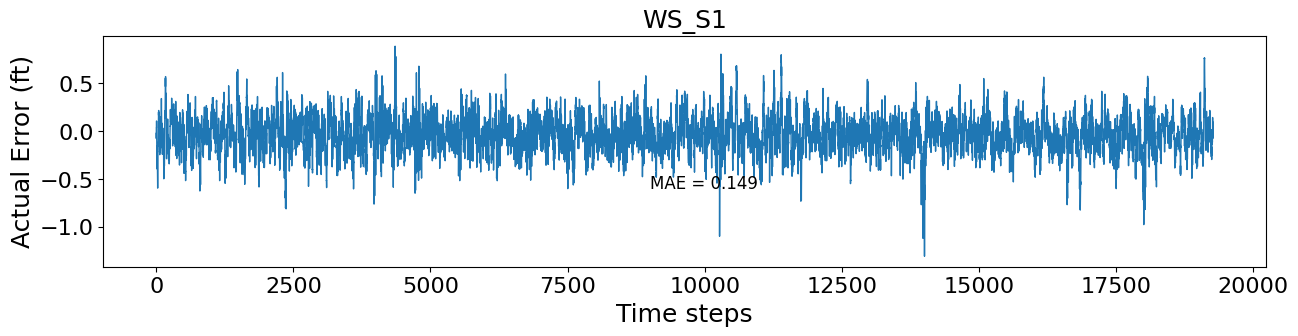

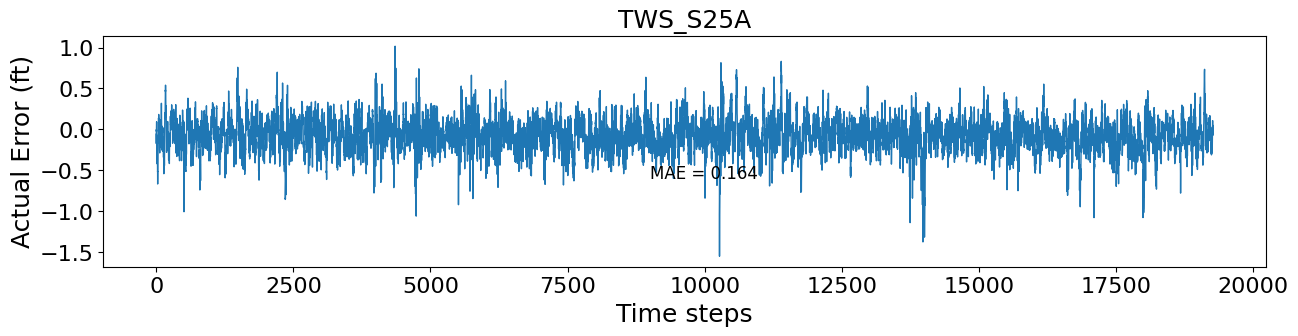

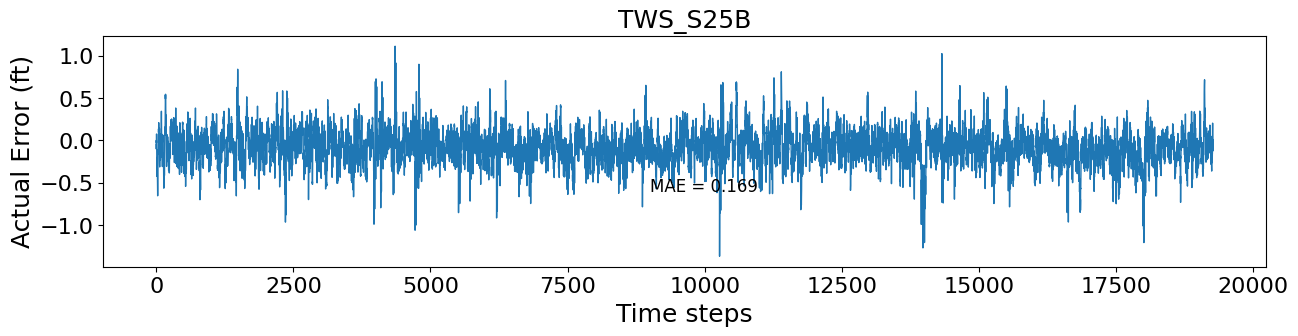

In [ ]:
wss = ['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
inv_yhat_reshape = inv_yhat.reshape((-1, 24, 4))
inv_y_reshape = inv_y.reshape((-1, 24, 4))

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    plt.plot(error[:, -1, i], linewidth=1)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Time steps', fontsize=18)
    plt.ylabel('Actual Error (ft)', fontsize=18)
    plt.title('{}'.format(wss[i]), fontsize=18)
    plt.text(9000, -0.6, 'MAE = {}'.format(float("{:.3f}".format(sum(abs(error[:, -1, i]))/len(error)))), fontsize=12)
    plt.show()

In [ ]:
up_thre = 0.5
low_thre = -0.5

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre) + np.sum(error[:, -1, i] < low_thre))

In [ ]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre))

In [ ]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] < low_thre))